In [1]:
import numpy as np
from CIR import get_CIR
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
from simulation import Simulation

from sklearn.preprocessing import MinMaxScaler, StandardScaler

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps'
print('Using device: ', device)

Using device:  mps


In [2]:
# I am setting v_0=b, so we start the process in its long-term mean

alpha = 0.6
b = 0.04
sigma = 0.14
v_0 = 0.04
years = 5
gamma = 0.4

sim = Simulation(alpha, b, sigma, v_0, years, gamma = gamma, seed=True)

In [3]:
# Simulate CIR process
# NB: time grid is measured in years, so end-point of time grid is `years`
grid = np.linspace(0., years, 365*years)

Creo io dei contratti artificiali a mano

In [4]:
arrival_times = np.array([i*380 for i in range(years)])
print('Simulation horizon: ', sim.TotPoints)
print('Arrival times: ', arrival_times)

Simulation horizon:  1825
Arrival times:  [   0  380  760 1140 1520]


In [5]:
arrival_time = [(i//380)*380 for i in range(sim.TotPoints)]
arrival_time[379]

0

In [6]:
def prepare_contract(arrival_time, sim, t):
    contract = np.zeros((5))
    contract[0] = int(arrival_time + 364 - t)/365                       #T-t/365 
    contract[1] = +1 #np.random.choice ([-1,1])                         #delta
    contract[2] = sim.Price(int(arrival_time), int(arrival_time + 364)) #p(t_0, T)
    contract[3] = sim.Price(int(t), int(arrival_time + 364))            #p(t, T)
    contract[4] = np.prod(1+(sim.CIRProcess[0:arrival_time+1]*1/365))   #B_t_0
    #contract[5] = sim.MarkToMarketPrice(+1, arrival_time, t, arrival_time +364)  #V(t)
    return contract
def get_arrival_time(t):
    return (t//380)*380


Riproduco una matrice dei contratti esattamente come farebbe la simulazione

In [7]:
X = []
#I need an auxiliary array that contains (t_0, T, delta) so that i can use `Simulation` methods to compute the targets M_t
X_for_simulation = []

for i in range(years):
    for t in range((i*380), np.minimum((i*380) + 364 +1, sim.TotPoints)):
        arrival_time = get_arrival_time(t)
        contract = prepare_contract(arrival_time, sim, t)
        X.append(contract)
        X_for_simulation.append(np.array([arrival_time, arrival_time + 364, +1]))
    
    for i in range(np.minimum((i*380) + 364, sim.TotPoints), np.minimum(((i+1) * 380) - 1, sim.TotPoints)):
        X.append(np.zeros((5)))
        X_for_simulation.append(np.zeros((3)))
        

In [8]:
print('Len X: ', len(X))
print('Len auxiliary X: ', len(X_for_simulation))

Len X:  1825
Len auxiliary X:  1825


### Compute targets M_t
Again we want to compute M_t up to T

In [9]:
X = torch.tensor(np.stack(X))
X_for_simulation = torch.tensor(np.stack(X_for_simulation))
training_index = int(0.8 * X.shape[0])

In [10]:
#see below why len(X)-1
targets = np.zeros((len(X)-1))
print(len(X))
for i in range(years):
    start_index = (i * 380)
    end_index = np.minimum((i*380) + 364, sim.TotPoints-1)
    a = np.asarray([sim.MarkToMarketPrice(+1, int(X_for_simulation[t+1,0]), t+1, int(X_for_simulation[t+1,1])) for t in range((i * 380), np.minimum((i*380) + 364, sim.TotPoints-1))])
    targets[ start_index : end_index] = a
    #targets[ start_index : end_index] = np.asarray([sim.GetInstantContractMarginValue(t+1, X_for_simulation[t+1]) for t in range((i * 380), np.minimum((i*380) + 364 , sim.TotPoints-1))])

1825


/Users/matteocitterio/Documents/Tesi/Generative models for financial networks/EvolveGCN/simulation.py:165: RuntimeWarning: divide by zero encountered in divide
  return np.where(condition, 0, (tau>0)*(-1 / tau) * ((price(t_0, T) - 1) / price(t_0, T)) )
/Users/matteocitterio/Documents/Tesi/Generative models for financial networks/EvolveGCN/simulation.py:165: RuntimeWarning: invalid value encountered in multiply
  return np.where(condition, 0, (tau>0)*(-1 / tau) * ((price(t_0, T) - 1) / price(t_0, T)) )


X goes from [0, 365 * years] but in order to compute V(t+1) we use X(t+1) so that we can compute in total 365*years-1 points, starting from t=0+1. Therefore i will use X[:,-1] as feature set and targets as target set

In [11]:
X = X[:-1]
print(X.shape)
targets = torch.tensor(targets).reshape(-1,1)
targets.shape

torch.Size([1824, 5])


torch.Size([1824, 1])

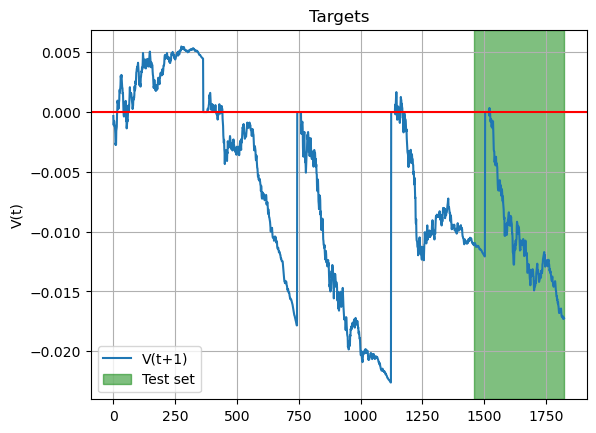

In [14]:
plt.title('Targets')
plt.plot(targets,label='V(t+1)')
#plt.plot(X[:,5], label='V(t)')
plt.axhline(0, c='r')
plt.axvspan(training_index,len(X), color='g', alpha=0.5, label='Test set')
plt.ylabel('V(t)')
plt.legend()
#plt.xlim(0,50)
plt.grid()
plt.show()

### Vediamo che T-t ci sono 

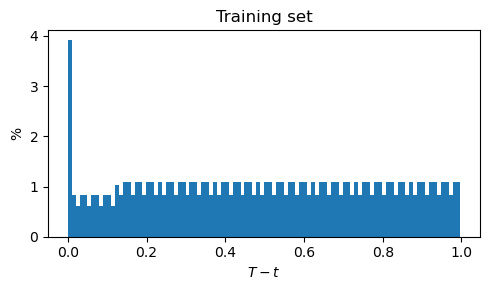

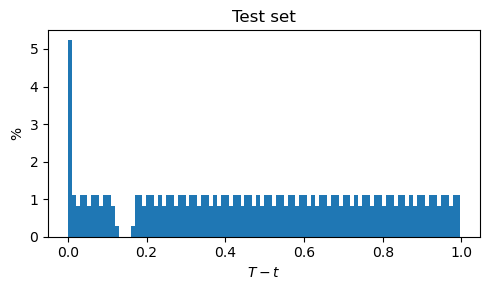

In [15]:
train = X[:training_index]
test = X[training_index:]

plt.figure(figsize=(5,3))
plt.hist(train[:,0],bins=100, density=True)
plt.title(f'Training set')
plt.ylabel('%')
plt.xlabel('$T-t$')
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3))
feat = []
plt.hist(test[:,0],bins=100, density=True)
plt.title(f'Test set')
plt.ylabel('%')
plt.xlabel('$T-t$')
plt.tight_layout()
plt.show()

In [16]:
#Normalizzazione
def scale_feature_matrix(feature_matrix, index):
    """
    Scales the feature matrix's feautures according to their type
    """
    #Get the maximum number of contracts
    num_contracts = int(feature_matrix.shape[1]/5)

    idx = index

    training_set = feature_matrix[0:idx]

    #Now slice them in 5 by 5, so that for every row we only have a contract
    combined_of_combined_training = np.vstack([training_set[:, 0 + (i*5): 5 + (i*5)] for i in range(num_contracts)])
    combined_of_combined = np.vstack([feature_matrix[:, 0 + (i*5): 5 + (i*5)] for i in range(num_contracts)])

    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Fit the scaler on the combined data and transform it
    scaler.fit(combined_of_combined_training)

    #I want to have it scaled so that the 1 is np.max * 1.5 and the 0 is np.min*0.5
    scaler.scale_ /= 1.25

    #Actually transform the data
    scaled_array = scaler.transform(combined_of_combined)

    # splits the vertical stack into a list of num_contracts elements
    pre_scaled_tensors = np.split(scaled_array, num_contracts, axis=0)
    #In order to recover the original tensor we need to stack horizontally the list's elements
    finally_tensors = torch.hstack([torch.tensor(pre_scaled_tensors[i]) for i in range(num_contracts)])

    #The last step is revert the first vertical stacking as well:

    #scaled_tensors = [finally_tensors[0 + i*num_nodes :num_nodes + i*num_nodes].squeeze() for i in range(len(dataset))]
    return finally_tensors


In [17]:
#X_data = scale_feature_matrix(X, training_index)
targets_scaler = MinMaxScaler()

targets_scaler.fit(targets[:training_index].cpu())
targets_scaler.scale_ /= 1.25
#targets =  targets_scaler.transform(targets.cpu())
#targets = torch.tensor(targets).to(torch.float32).to(device)

In [18]:
X_data = X

In [19]:
#La simulazione è lunga years ma il dataset è years-1 perchè se no l'ultimo punto non lo predico.
#Uso years-1 per creare Bt poi uso [1:years] come variabile di conditioning così che rimane allineata ai
#Targets
CIRProcess = sim.CIRProcess[:-1]
B_t = np.asarray([np.prod(1+(CIRProcess[0:t]*1/365)) for t in range(1,len(CIRProcess)+1)])
B_t = torch.tensor(B_t.reshape(-1,1)).to(torch.float32).to(device)
CIRProcess = torch.tensor(sim.CIRProcess[1:].reshape(-1,1)).to(torch.float32).to(device)

scaler_CIR = MinMaxScaler()
scaler_CIR.fit(CIRProcess[0:training_index].cpu().reshape(-1,1))
scaler_CIR.scale_ /= 1.25
#CIRProcess = torch.tensor(scaler_CIR.transform(CIRProcess.cpu().reshape(-1,1))).to(torch.float32).to(device)

scaler_Bt = MinMaxScaler()
scaler_Bt.fit(B_t[0:training_index].cpu().reshape(-1,1))
scaler_Bt.scale_ /= 1.25
#B_t = torch.tensor(scaler_Bt.transform(B_t.cpu().reshape(-1,1))).to(torch.float32).to(device)

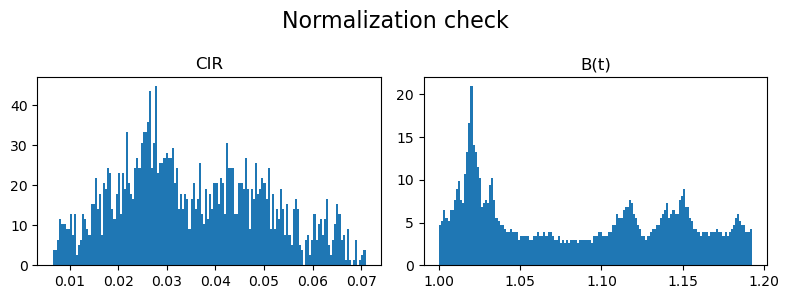

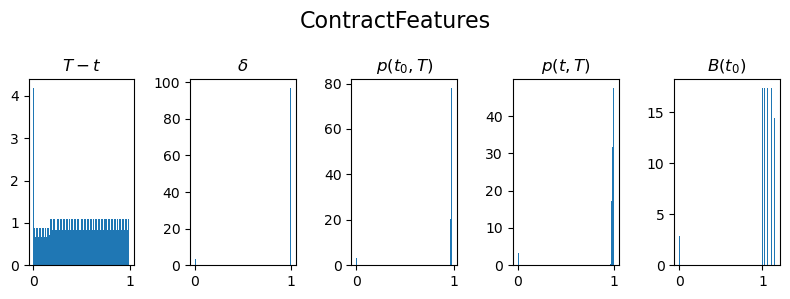

In [20]:
#Controlliamo la normalizzazione:
plt.figure(figsize=(8,3))
plt.suptitle('Normalization check', fontsize=16)
plt.subplot(1,2,1)
plt.hist(CIRProcess.cpu().squeeze(), bins=150, density=True)
plt.title('CIR')
plt.subplot(1,2,2)
plt.hist(B_t.cpu().squeeze(), bins=150, density=True)
plt.title('B(t)')
plt.tight_layout()
plt.show()

features_names = ['$T-t$', '$\delta$', '$p(t_0,T)$','$p(t,T)$', '$B(t_0)$']

plt.figure(figsize=(8,3))
plt.suptitle('ContractFeatures', fontsize=16)
for i in range(5):
    plt.subplot(1,5,1+i)
    plt.hist(X_data[:, i],bins=100, density=True)
    plt.title(f'{features_names[i]}')

plt.tight_layout()
plt.show()

In [21]:
X_data = X_data.to(torch.float32).to(device)
#Concat in the data matrix, Targets is not actually useful but im gonna keep it for the moment
X_data = torch.cat([X_data, B_t], axis = 1).to(device)
print('X_data.shape: ', X_data.shape)

X_data.shape:  torch.Size([1824, 6])


In [22]:
def create_dataset_all_sequence(dataset,r,targets, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y, reference = [], [], []
    
    for i in range(len(dataset)-lookback):
        
        feature = dataset[i : i + lookback, :]
        #Sia target che CIR process sono allineati già a one step ahead quindi si tengono questi indici
        target = targets[i  : i + lookback ]
        r_temp = r[i : i + lookback ]

        X.append(feature.to(torch.float32))
        y.append(target.to(torch.float32))
        reference.append(r_temp.to(torch.float32))

    return torch.stack(X).to(device), torch.stack(y).to(device), torch.stack(reference).to(device)


In [23]:
from torch.utils.data import TensorDataset, Dataset, DataLoader, Subset

In [24]:
# Create train and test sets
train, targets_train, CIR_train = X_data[:training_index,:], targets[:training_index], CIRProcess[:training_index]
test, targets_test, CIR_test = X_data[training_index:,:], targets[training_index:], CIRProcess[training_index:]

lookback = 10
X_train, y_train, r_train = create_dataset_all_sequence(train, CIR_train, targets_train, lookback=lookback)
X_test, y_test, r_test = create_dataset_all_sequence(test,CIR_test, targets_test, lookback=lookback)

print(f'Training: X {X_train.shape} y:{y_train.shape}, r:{r_train.shape}')
print(f'Test X {X_test.shape} y:{y_test.shape}, r:{r_test.shape}')

train_dataset = torch.utils.data.TensorDataset(X_train.to(device), y_train.to(device), r_train.to(device))
test_dataset = torch.utils.data.TensorDataset(X_test.to(device), y_test.to(device), r_test.to(device))

loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=200)
loader_test = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size = 100)


Training: X torch.Size([1450, 10, 6]) y:torch.Size([1450, 10, 1]), r:torch.Size([1450, 10, 1])
Test X torch.Size([354, 10, 6]) y:torch.Size([354, 10, 1]), r:torch.Size([354, 10, 1])


In [25]:
from torch.utils.data import TensorDataset, DataLoader, Subset

class model(nn.Module):

    def __init__(self):
        super(model, self).__init__()

        input_size = 6
        lstm_hidden_size = 15
        lstm_n_layers = 1
        regressor_hidden_size = 32

        self.lstm = torch.nn.LSTM(input_size=input_size, 
                             hidden_size=lstm_hidden_size, 
                             num_layers=lstm_n_layers)

        #Il +1 è perchè facciamo il concat con il reference interest rate
        self.regressor = nn.Sequential(nn.Linear(lstm_hidden_size+1, regressor_hidden_size),
                                       nn.ReLU(),
                                       nn.Dropout(0.1),
                                       nn.Linear(regressor_hidden_size, 1))

    def forward(self, x, r):
        lstm_hidden, _ = self.lstm(x)
        return self.regressor(torch.squeeze(torch.cat([lstm_hidden[:,-1,:], r[:,-1,:]],dim=1)))


In [26]:
lr = 1e-2

criterion = nn.MSELoss()

mymodel = model().to(device)

optimizer = torch.optim.Adam(mymodel.parameters(), lr=lr)

n_epochs = 5000

loop = tqdm(range(n_epochs))

train_loss = []
val_loss = []

best_val_loss = float('inf')  # Initialize with a large value
patience = 50  # Number of consecutive epochs to wait for improvement
counter = 0  # Counter for consecutive epochs without improvement

for epoch in loop:
    mymodel.train()
    temp_loss_train = 0
    for X, y, r in loader:
        y_pred = mymodel(X,r)
        loss = criterion(y_pred, y[:,-1,:])        
        loss.backward()
        optimizer.step() 
        optimizer.zero_grad()
        temp_loss_train += loss.item()
    train_loss.append(temp_loss_train/len(loader))
    if epoch % 50 == 0:
        temp_loss_val = 0
        with torch.no_grad():
            for X, y, r in loader_test:
                y_pred = mymodel(X,r)
                loss = criterion(y_pred, y[:,-1,:])        
                temp_loss_val += loss.item()
                val_loss.append(temp_loss_val / len(loader_test))

        # Early stopping
        if val_loss[-1] < best_val_loss:
            best_val_loss = val_loss[-1]
            best_train_loss = train_loss[-1]
            torch.save(mymodel.state_dict(),'temp_state_dict.pt')
            counter = 0
        else:
            counter += 1

        if counter >= patience:
            mymodel.load_state_dict(torch.load('temp_state_dict.pt'))
            print(f"Early stopping at epoch {epoch}. Best Validation RMSE: {np.sqrt(best_val_loss)} with train RMSE:{np.sqrt(best_train_loss)}")
            break
    
    loop.set_postfix(loss = temp_loss_train/len(loader), val_loss = val_loss[-1], best_val_loss = best_val_loss, counter=counter)


  0%|          | 0/5000 [00:00<?, ?it/s]

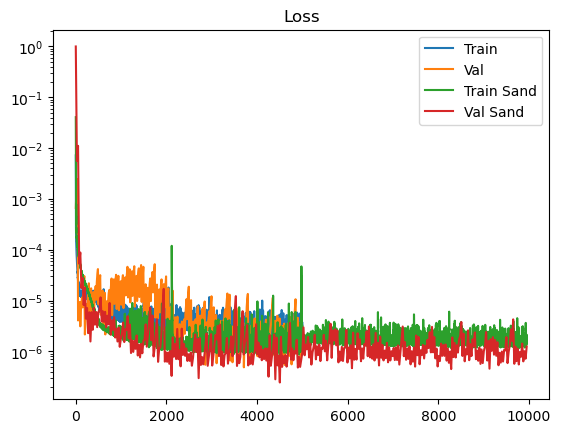

In [113]:
plt.title('Loss')
val_epochs = np.linspace(0, len(train_loss), num=len(val_loss))
train_loss_sandbox = np.load(f'/Volumes/data/train_loss_Sandbox.npy')
val_loss_sandbox =  np.load(f'/Volumes/data/val_loss_Sandbox.npy')
val_epochs_sand = np.linspace(0, len(train_loss_sandbox), num=len(val_loss_sandbox))
plt.plot(train_loss, label = 'Train')
plt.plot(val_epochs, val_loss, label = 'Val')
plt.plot(train_loss_sandbox, label = 'Train Sand')
plt.plot(val_epochs_sand, val_loss_sandbox, label = 'Val Sand')
plt.legend()
plt.yscale('log')

In [28]:
def predict(model, loader, loader_test):
    model.eval()
    train_predictions = []
    train_labels = []
    test_predictions = []
    test_labels = []

    with torch.no_grad():

        loop = tqdm(loader, desc='Train prediction')
    
        for X_batch, y_batch, r_batch in loop:
    
            y_pred = model(X_batch, r_batch)
    
            for j in range(y_pred.shape[0]):
                
                train_predictions.append(y_pred[j,-1].detach())
                train_labels.append(y_batch[j,-1].detach())
                
        loop = tqdm(loader_test, desc='Test prediction')
    
        for X_batch, y_batch, r_batch in loop:
    
            y_pred = model(X_batch, r_batch)
    
            for j in range(y_pred.shape[0]):
                
                test_predictions.append(y_pred[j,-1].detach())
                test_labels.append(y_batch[j,-1].detach())

    return torch.stack(train_predictions), torch.stack(train_labels), torch.stack(test_predictions), torch.stack(test_labels),


In [77]:
loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train, r_train), shuffle=False, batch_size=100)
loader_test = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test, r_test), shuffle=False, batch_size=100)
#Save predictions
train_pred, train_label, test_pred, test_label= predict(mymodel, loader, loader_test)

Train prediction:   0%|          | 0/15 [00:00<?, ?it/s]

Test prediction:   0%|          | 0/4 [00:00<?, ?it/s]

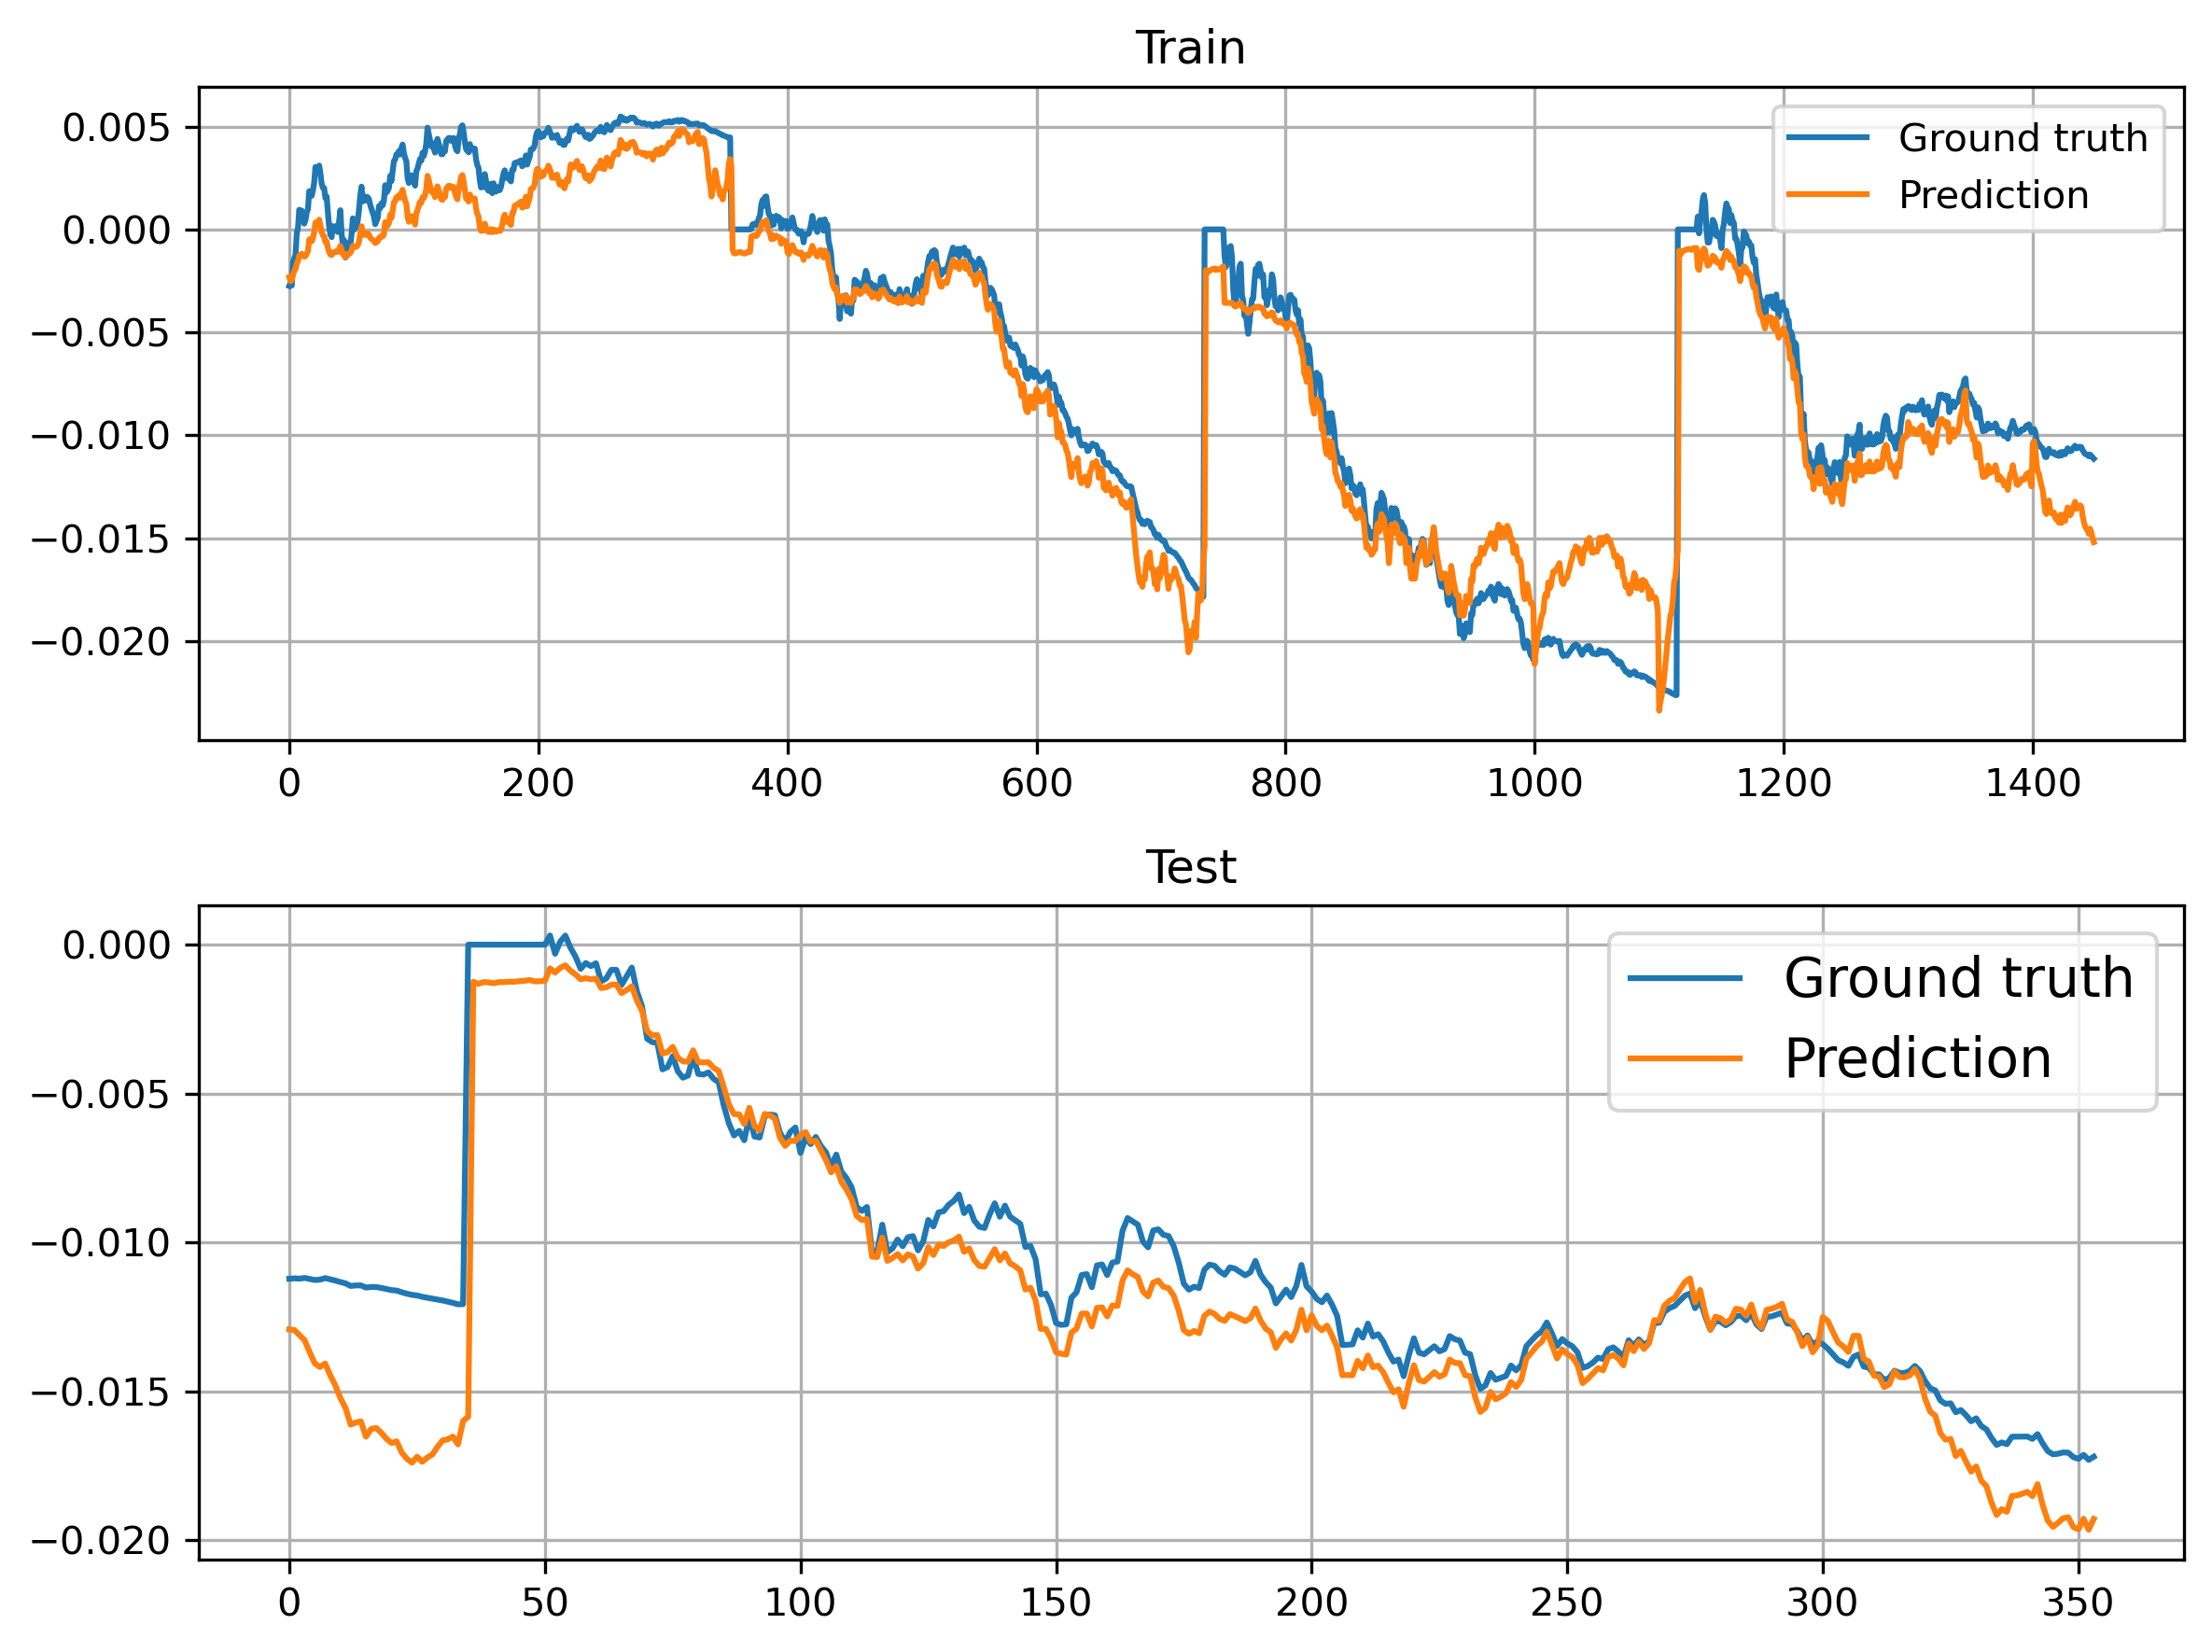

In [78]:
plt.figure(figsize=(8,6), dpi=300)
plt.subplot(2,1,2)
plt.plot(test_label.cpu(), label='Ground truth')
plt.plot(test_pred.cpu(), label='Prediction')
plt.grid()
plt.legend(fontsize=14)
plt.title('Test')

plt.subplot(2,1,1)
plt.title('Train')
#plt.xlim(1000,1200)
plt.plot(train_label.cpu(), label='Ground truth')
plt.plot(train_pred.cpu(), label='Prediction')
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig('15_128_training')
plt.show()

**From a script version of the notebook**: By feeding V(t) in the features matrix, the prediction is of course better

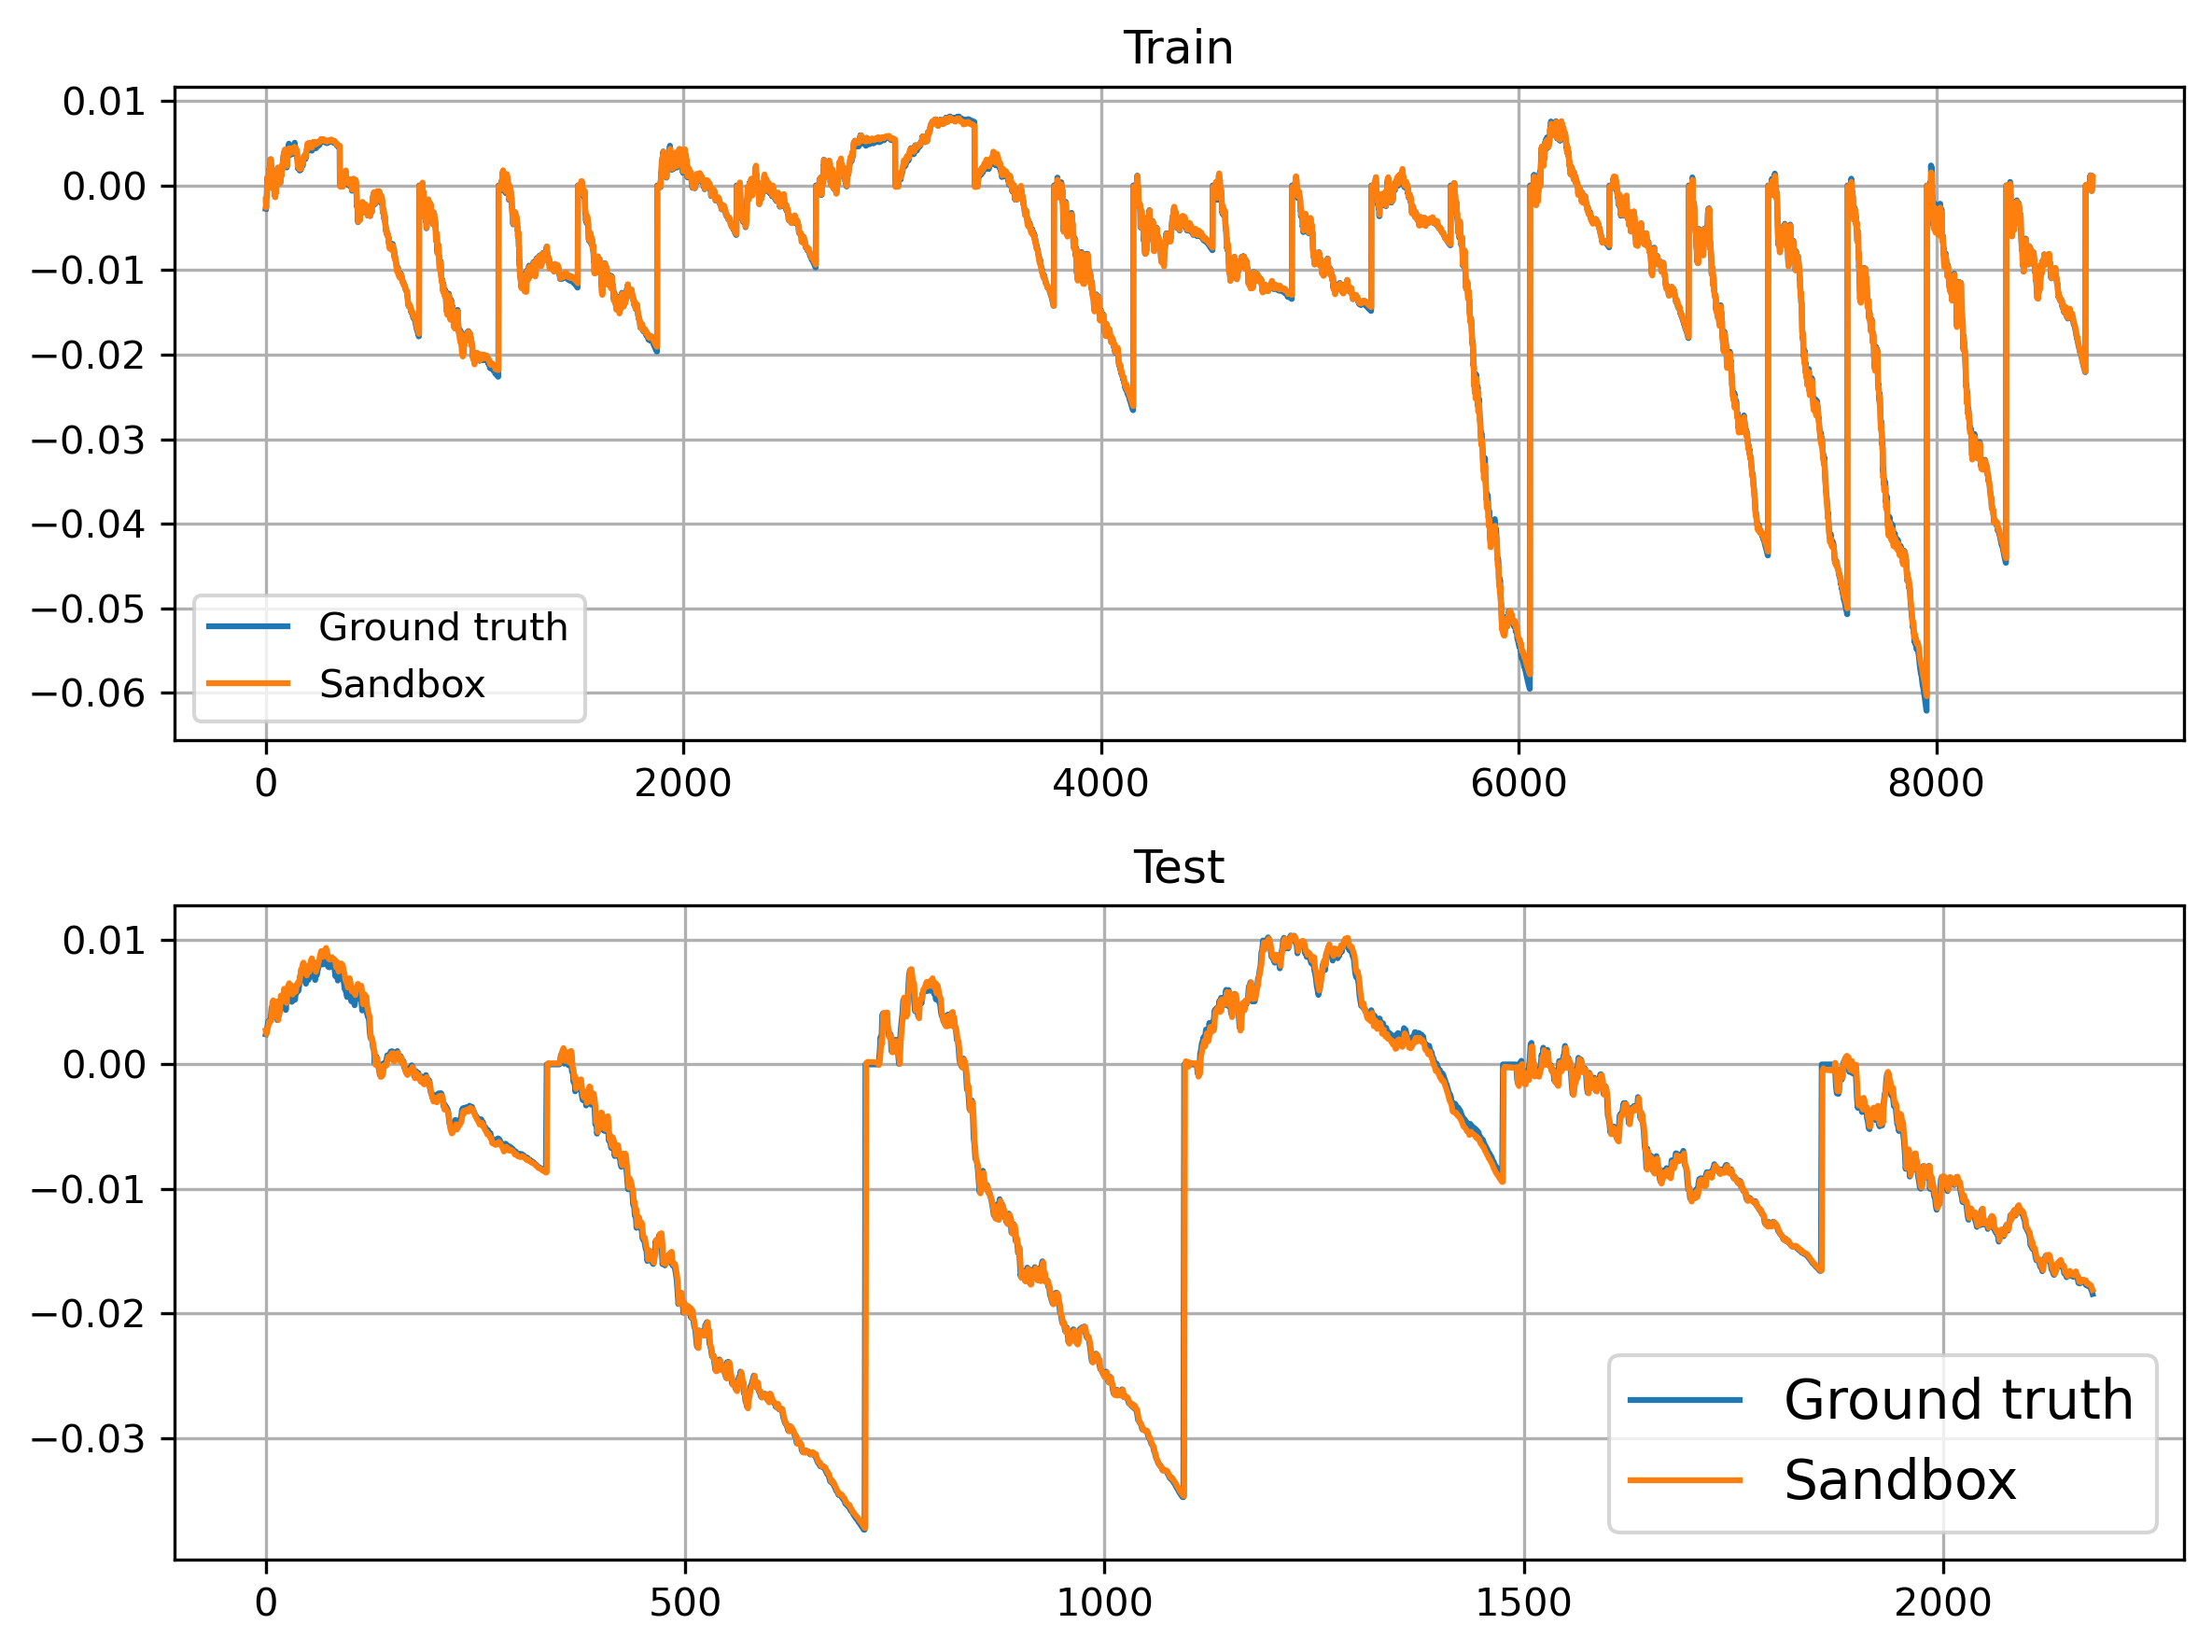

In [115]:
test_label = np.load(f'/Volumes/data/test_label_Sandbox.npy')
train_label = np.load(f'/Volumes/data/train_label_Sandbox.npy')
test_pred = np.load(f'/Volumes/data/test_pred_Sandbox.npy')
train_pred = np.load(f'/Volumes/data/train_pred_Sandbox.npy')

plt.figure(figsize=(8,6), dpi=300)
plt.subplot(2,1,2)
plt.plot(test_label, label='Ground truth')
plt.plot(test_pred, label = f'Sandbox')
plt.grid()
plt.legend(fontsize=14)
plt.title('Test')

plt.subplot(2,1,1)
plt.title('Train')
plt.plot(train_label, label='Ground truth')
plt.plot(train_pred, label = f'Sandbox')
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig('15_128_training')
plt.show()